## 1. Install libs

In [5]:
import torch
import numpy as np
import yaml
from ultralytics import YOLO
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import shutil
import os

import xml.etree.ElementTree as ET
import glob
import json

# Configuração para que os gráficos apareçam no notebook
%matplotlib inline

print("Libraries successfully imported!")

Libraries successfully imported!


### Global Base Path

In [6]:
# Pega o diretório atual automaticamente
BASE_DIR = Path().resolve()

# Sobe um nível e entra na pasta dataset
DATASET_DIR = BASE_DIR.parent / "dataset"

print("Current path:", BASE_DIR)
print("Dataset path:", DATASET_DIR)

Current path: C:\Users\Seares\Desktop\Programação\Projetos\Cases Técnicos\CloudWalk-case\notebooks
Dataset path: C:\Users\Seares\Desktop\Programação\Projetos\Cases Técnicos\CloudWalk-case\dataset


### Auxiliary Functions


In [7]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]


def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]

## 2. Convert the labels: PASCAL VOC (XML) to YOLO (TXT)

In [9]:
classes = []
input_dir = "../dataset/sp-pools/labels/"
output_dir = "../dataset/sp-pools_labels_yolo/"
image_dir = "../dataset/sp-pools/images/"

# create the labels folder (output directory)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))

for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        


        pil_bbox = [xmin, ymin, xmax, ymax]

        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)

        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))
    
print("XML to YOLO Format Done!!")

XML to YOLO Format Done!!


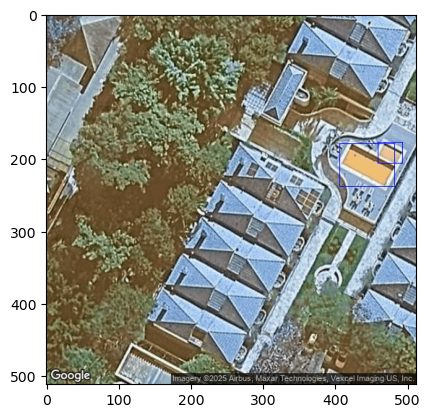

In [10]:
## Just for visualization the image from dataset

img = cv2.imread("../dataset/sp-pools/images/sp_Alto_de_Pinheiros_0245_-23.554000_-46.716714.png")
dh, dw, _ = img.shape

fl = open("../dataset/sp-pools_labels_yolo/sp_Alto_de_Pinheiros_0245_-23.554000_-46.716714.txt", 'r')
data = fl.readlines()
fl.close()

for dt in data:

    _, x, y, w, h = map(float, dt.split(' '))

    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.imshow(img)
plt.show()

## 3. Train Test Split


In [12]:
IMAGES_PATH = DATASET_DIR / "sp-pools/images"
LABELS_PATH = DATASET_DIR / "sp-pools_labels_yolo/"

OUTPUT_SPLIT_DIR = DATASET_DIR / "fine_tuning/yolo_dataset_split"

all_images = [file for file in os.listdir(IMAGES_PATH) if file.endswith('.png')]

images_with_labels = []
images_without_labels = []

for img_file in all_images:
    label_file = f"{img_file[:-4]}.txt"
    if os.path.exists(LABELS_PATH / label_file):
        images_with_labels.append(img_file)
    else:
        images_without_labels.append(img_file)

print(f"Imagens COM piscinas: {len(images_with_labels)}")
print(f"Imagens SEM piscinas: {len(images_without_labels)}")

all_images_for_split = images_with_labels + images_without_labels

# Split data
train, temp = train_test_split(all_images_for_split, test_size=0.3, shuffle=True, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, shuffle=True, random_state=42)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

os.makedirs(OUTPUT_SPLIT_DIR / "test/images", exist_ok=True)
os.makedirs(OUTPUT_SPLIT_DIR / "test/labels", exist_ok=True)
os.makedirs(OUTPUT_SPLIT_DIR / "train/images", exist_ok=True)
os.makedirs(OUTPUT_SPLIT_DIR / "train/labels", exist_ok=True)
os.makedirs(OUTPUT_SPLIT_DIR / "valid/images", exist_ok=True)
os.makedirs(OUTPUT_SPLIT_DIR / "valid/labels", exist_ok=True)

def move_files_to_dir(image_files, dirname):
    for image_filename in image_files:
        label_filename = f"{image_filename[:-4]}.txt"
        
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{dirname}/images/{image_filename}")
        
        if os.path.exists(f"{LABELS_PATH}/{label_filename}"):
            shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{dirname}/labels/{label_filename}")
        else:
            # Make empty file for images without pools
            open(f"{dirname}/labels/{label_filename}", 'w').close()

# Move splits to folders
move_files_to_dir(train, OUTPUT_SPLIT_DIR / "train")
move_files_to_dir(test, OUTPUT_SPLIT_DIR / "test")
move_files_to_dir(valid, OUTPUT_SPLIT_DIR / "valid")

print("Train Test Split Done!!")
print("Folders Local: ", OUTPUT_SPLIT_DIR)

Imagens COM piscinas: 116
Imagens SEM piscinas: 191
train: 214; valid: 46; test: 47
Train Test Split Done!!
Folders Local:  C:\Users\Seares\Desktop\Programação\Projetos\Cases Técnicos\CloudWalk-case\dataset\fine_tuning\yolo_dataset_split


## 4. Training Model


### Create a dataset yaml config

In [13]:
def create_dataset_yaml():
    """
    Create config file for dataset
    """
    absolute_split_path = os.path.abspath(OUTPUT_SPLIT_DIR)
    
    dataset_config = {
        'path': absolute_split_path,
        
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        
        'nc': 1,            # Number of classes (Just one: pool)
        'names': ['pool']   # Name of the classes (index 0)
    }

    yaml_path = os.path.join(DATASET_DIR, 'fine_tuning/fine_tuning.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)

    print(f"Arquivo dataset.yaml criado: {yaml_path}")
    return yaml_path

In [14]:
yaml_config = create_dataset_yaml()

Arquivo dataset.yaml criado: C:\Users\Seares\Desktop\Programação\Projetos\Cases Técnicos\CloudWalk-case\dataset\fine_tuning/fine_tuning.yaml


In [15]:
model_path = '../models/results_pools/pools_detector_v4/weights/best.pt'
model = YOLO(model_path)

os.makedirs('../models/fine_tuning', exist_ok=True)

results = model.train(
    data=yaml_config,
    epochs=80,
    imgsz=512,  
    batch=16,    # ajustado pra 8GB de VRAM
    device=0 if torch.cuda.is_available() else 'cpu',
    project='../models/fine_tuning',
    name='pools_fine_tuning_v3',
    save=True,
    plots=True,
    patience=15,
    verbose=True,
    exist_ok=True
)


New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.218  Python-3.10.18 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Seares\Desktop\Programao\Projetos\Cases Tcnicos\CloudWalk-case\dataset\fine_tuning/fine_tuning.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/results_


image 1/1 C:\Users\Seares\Desktop\Programao\Projetos\Cases Tcnicos\CloudWalk-case\notebooks\..\dataset\sao_paulo_random_images\images\sp_Zona_Sul_0308_-23.636389_-46.702231.png: 512x512 5 pools, 26.0ms
Speed: 1.7ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\Seares\Desktop\Programao\Projetos\Cases Tcnicos\CloudWalk-case\notebooks\..\dataset\sao_paulo_random_images\images\sp_Centro_0023_-23.551169_-46.614799.png: 512x512 2 pools, 11.6ms
Speed: 0.8ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\Seares\Desktop\Programao\Projetos\Cases Tcnicos\CloudWalk-case\notebooks\..\dataset\fine_tuning\yolo_dataset_split\test\images\sp_Alto_de_Pinheiros_0258_-23.552857_-46.711000.png: 512x512 1 pool, 11.5ms
Speed: 0.9ms preprocess, 11.5ms inference, 3.2ms postprocess per image at shape (1, 3, 512, 512)


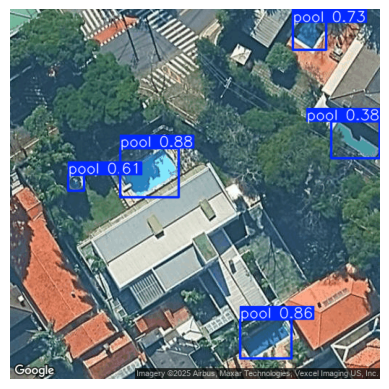

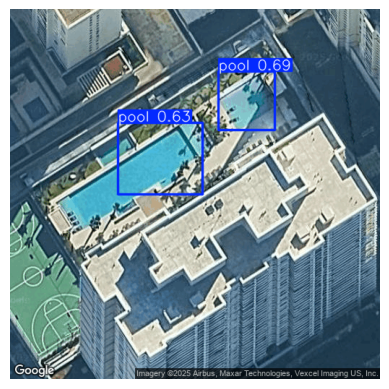

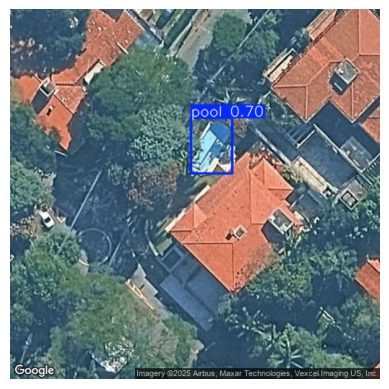

In [47]:
# Insira o modelo treinado
best_model = YOLO("../models/fine_tuning/pools_fine_tuning_v3/weights/best.pt")

preds = best_model.predict("../dataset/sao_paulo_random_images/images/sp_Zona_Sul_0308_-23.636389_-46.702231.png", iou=0.5)
preds2 = best_model.predict("../dataset/sao_paulo_random_images/images/sp_Centro_0023_-23.551169_-46.614799.png", iou=0.05)
preds3 = best_model.predict("../dataset/fine_tuning/yolo_dataset_split/test/images/sp_Alto_de_Pinheiros_0258_-23.552857_-46.711000.png", iou=0.05)

result_img = preds[0].plot()    # BGR
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

result_img2 = preds2[0].plot()  # BGR
result_img2 = cv2.cvtColor(result_img2, cv2.COLOR_BGR2RGB)

result_img3 = preds3[0].plot()  # BGR
result_img3 = cv2.cvtColor(result_img3, cv2.COLOR_BGR2RGB)

plt.imshow(result_img)
plt.axis("off")
plt.show()

plt.imshow(result_img2)
plt.axis("off")
plt.show()

plt.imshow(result_img3)
plt.axis("off")
plt.show()
